### Producten week 3-4

In [39]:
%config IPCompleter.greedy = True
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
# data uitlezen
def read_vektis_data(dir, start, end):
    dfArray = []

    for i in range(start, end):
        df = pd.read_csv(f'{dir}/vektis_20{i}.csv', sep=';', dtype={'geslacht': str, 'leeftijdsklasse': str}, low_memory=False)
        df.columns = df.columns.str.lower()
        df['jaar'] = 2000 + i
        dfArray.append(df)

    return pd.concat(dfArray)

# Read the data - data van voor 2015 mist veel GGZ data en is dus weggelaten
df = read_vektis_data('./Vektis', 15, 21)

# Veel null waarden op kosten_eerstelijnsverblijf, dus die kolom droppen
df = df.drop(columns=['kosten_eerstelijnsverblijf'])

# if column kosten_gzsp is not null then concat kosten_gzsp and kosten_overig into kosten_overig
df['kosten_overig'] = df.apply(lambda row: row['kosten_gzsp'] if pd.notnull(row['kosten_gzsp']) else row['kosten_overig'], axis=1)
df = df.drop(columns=['kosten_gzsp']).dropna()

In [41]:
ov = pd.read_csv('./Rivm/overgewicht.csv', sep=';', na_values='       .').drop(columns=('Marges')).dropna()
ro = pd.read_csv('./Rivm/roken.csv', sep=';', na_values='       .').drop(columns=('Marges')).dropna()
ee = pd.read_csv('./Rivm/eenzaamheid.csv', sep=';', na_values='       .').drop(columns=('Marges')).dropna()
rv = ov.merge(ro, on=['Leeftijd', 'WijkenEnBuurten', 'Perioden', 'Gemeentenaam_1'], how='left').drop(columns=['ID_y'])
rv = rv.merge(ee, on=['Leeftijd', 'WijkenEnBuurten', 'Perioden', 'Gemeentenaam_1'], how='left').drop(columns=['ID'])

rv.info()
print(rv.head())

mv = rv.interpolate(method='linear', limit_direction='forward')
mv = mv.astype({ 'Ondergewicht_7': float, 'NormaalGewicht_8': float, 'Overgewicht_9': float, 'ErnstigOvergewicht_10' : float, 'Roker_11' : float, 'Eenzaam_28' : float, 'ErnstigZeerErnstigEenzaam_29' : float, 'EmotioneelEenzaam_30' : float, 'SociaalEenzaam_31' : float }).drop(columns=['ID_x', 'WijkenEnBuurten'])
mv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1042083 entries, 0 to 1042082
Data columns (total 14 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   ID_x                          1042083 non-null  int64  
 1   Leeftijd                      1042083 non-null  int64  
 2   WijkenEnBuurten               1042083 non-null  object 
 3   Perioden                      1042083 non-null  object 
 4   Gemeentenaam_1                1042083 non-null  object 
 5   Ondergewicht_7                1042083 non-null  float64
 6   NormaalGewicht_8              1042083 non-null  float64
 7   Overgewicht_9                 1042083 non-null  float64
 8   ErnstigOvergewicht_10         1042083 non-null  float64
 9   Roker_11                      1042083 non-null  float64
 10  Eenzaam_28                    893754 non-null   float64
 11  ErnstigZeerErnstigEenzaam_29  893754 non-null   float64
 12  EmotioneelEenzaam_30        

In [42]:
leeftijdMeta = pd.read_csv('./Rivm/Metadata/leeftijd.csv', sep=';')
periodenMeta = pd.read_csv('./Rivm/Metadata/perioden.csv', sep=';')
wijkEnBuurt = pd.read_csv('./Rivm/Metadata/brt2020.csv', sep=';', encoding="ISO-8859-1")

def replaceMeta(data, meta, column_to_replace, column_to_use):
    for index, row in meta.iterrows():
        data = data.replace(row[column_to_replace], row[column_to_use])
    return data

mv = replaceMeta(mv, leeftijdMeta, 'Key', 'Title')
mvCombined = replaceMeta(mv, periodenMeta, 'Key', 'Title')

In [43]:
mvCombined['gemeentenaam'] = mvCombined['Gemeentenaam_1'].str.lower().str.strip()
mvCombined['jaar'] = mvCombined['Perioden']
mvCombined.drop(columns=['Gemeentenaam_1', 'Perioden'], inplace=True)

In [44]:
# def interpolateMissingYears(d):
#     # create a new dataframe with all the years
#     years = pd.DataFrame({'jaar': range(2013, 2020)})
#     years['key'] = 1

#     # create a new dataframe with all the gemeentes
#     gemeentes = pd.DataFrame({'gemeentenaam': d['gemeentenaam'].unique()})
#     gemeentes['key'] = 1

#     # create a new dataframe with all the leeftijden
#     leeftijden = pd.DataFrame({'Leeftijd': d['Leeftijd'].unique()})
#     leeftijden['key'] = 1

#     # create a new dataframe with all the combinations of gemeentes, leeftijden and years
#     df = gemeentes.merge(leeftijden, on='key').merge(years, on='key').drop(columns=['key'])

#     # merge the new dataframe with the existing data
#     df = df.merge(d, on=['gemeentenaam', 'Leeftijd', 'jaar'], how='left')

#     # interpolate the missing data
#     df['Ondergewicht_7'] = df.groupby(['gemeentenaam', 'Leeftijd'])['Ondergewicht_7'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
#     df['NormaalGewicht_8'] = df.groupby(['gemeentenaam', 'Leeftijd'])['NormaalGewicht_8'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
#     df['Overgewicht_9'] = df.groupby(['gemeentenaam', 'Leeftijd'])['Overgewicht_9'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
#     df['ErnstigOvergewicht_10'] = df.groupby(['gemeentenaam', 'Leeftijd'])['ErnstigOvergewicht_10'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
#     df['Roker_11'] = df.groupby(['gemeentenaam', 'Leeftijd'])['Roker_11'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
#     df['Eenzaam_28'] = df.groupby(['gemeentenaam', 'Leeftijd'])['Eenzaam_28'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
#     df['ErnstigZeerErnstigEenzaam_29'] = df.groupby(['gemeentenaam', 'Leeftijd'])['ErnstigZeerErnstigEenzaam_29'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
#     df['EmotioneelEenzaam_30'] = df.groupby(['gemeentenaam', 'Leeftijd'])['EmotioneelEenzaam_30'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
#     df['SociaalEenzaam_31'] = df.groupby(['gemeentenaam', 'Leeftijd'])['SociaalEenzaam_31'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))

#     # sort by gemeentenaam, leeftijd and jaar
#     df = df.sort_values(by=['gemeentenaam', 'Leeftijd', 'jaar'])

#     return df

# mvI = interpolateMissingYears(mvCombined)

mvI = mvCombined

In [45]:
def leeftijdToCat(d):
    for index, row in d.iterrows():
        if (row['leeftijdsklasse'] == '15 t/m 19 jaar'):
            d.loc[index, 'Leeftijd'] = '18 jaar of ouder'
        elif (row['leeftijdsklasse'] == '20 t/m 24 jaar'):
            d.loc[index, 'Leeftijd'] = '18 jaar of ouder'
        elif (row['leeftijdsklasse'] == '25 t/m 29 jaar'):
            d.loc[index, 'Leeftijd'] = '18 jaar of ouder'
        elif (row['leeftijdsklasse'] == '30 t/m 34 jaar'):
            d.loc[index, 'Leeftijd'] = '18 jaar of ouder'
        elif (row['leeftijdsklasse'] == '35 t/m 39 jaar'):
            d.loc[index, 'Leeftijd'] = '18 jaar of ouder'
        elif (row['leeftijdsklasse'] == '40 t/m 44 jaar'):
            d.loc[index, 'Leeftijd'] = '18 jaar of ouder'
        elif (row['leeftijdsklasse'] == '45 t/m 49 jaar'):
            d.loc[index, 'Leeftijd'] = '18 jaar of ouder'
        elif (row['leeftijdsklasse'] == '50 t/m 54 jaar'):
            d.loc[index, 'Leeftijd'] = '18 jaar of ouder'
        elif (row['leeftijdsklasse'] == '55 t/m 59 jaar'):
            d.loc[index, 'Leeftijd'] = '18 jaar of ouder'
        elif (row['leeftijdsklasse'] == '60 t/m 64 jaar'):
            d.loc[index, 'Leeftijd'] = '18 jaar of ouder'
        elif (row['leeftijdsklasse'] == '65 t/m 69 jaar'):
            d.loc[index, 'Leeftijd'] = '18 jaar of ouder'
        elif (row['leeftijdsklasse'] == '70 t/m 74 jaar'):
            d.loc[index, 'Leeftijd'] = '18 jaar of ouder'
        elif (row['leeftijdsklasse'] == '75 t/m 79 jaar'):
            d.loc[index, 'Leeftijd'] = '65 jaar of ouder'
        elif (row['leeftijdsklasse'] == '18 jaar of ouder'):
            d.loc[index, 'Leeftijd'] = '65 jaar of ouder'
        elif (row['leeftijdsklasse'] == '85 t/m 89 jaar'):
            d.loc[index, 'Leeftijd'] = '18 jaar of ouder'
        elif (row['leeftijdsklasse'] == '90+'):
            d.loc[index, 'Leeftijd'] = '18 jaar of ouder'

    return d

df['leeftijdsklasse'] = df['leeftijdsklasse'].str.lower().str.strip()
df['gemeentenaam'] = df['gemeentenaam'].str.lower().str.strip()
df['Leeftijd'] = None
dfe = leeftijdToCat(df)

dfen = dfe.dropna(subset=['Leeftijd'])
mvI.astype({'jaar': 'int64'})

,Leeftijd,Ondergewicht_7,NormaalGewicht_8,Overgewicht_9,ErnstigOvergewicht_10,Roker_11,Eenzaam_28,ErnstigZeerErnstigEenzaam_29,EmotioneelEenzaam_30,SociaalEenzaam_31,gemeentenaam,jaar
0,18 jaar of ouder,2.0,49.7,48.5,12.9,24.1,NaN,NaN,NaN,NaN,nederland,2012
1,18 jaar of ouder,2.0,49.7,48.5,12.9,23.8,NaN,NaN,NaN,NaN,nederland,2012
2,18 jaar of ouder,2.0,49.7,48.5,12.9,24.3,NaN,NaN,NaN,NaN,nederland,2012
3,18 jaar of ouder,1.8,48.8,49.3,14.3,21.7,43.4,10.1,23.0,30.9,nederland,2016
4,18 jaar of ouder,1.8,48.8,49.3,14.3,21.7,43.2,9.9,22.7,30.6,nederland,2016
...,...,...,...,...,...,...,...,...,...,...,...,...
1042078,18 jaar of ouder,3.4,55.6,53.9,16.0,8.2,33.1,3.4,14.3,19.3,zwolle,2020
1042079,18 jaar of ouder,3.4,55.6,53.9,16.0,8.2,44.0,8.9,23.2,29.0,zwolle,2020
1042080,18 jaar of ouder,3.4,55.6,53.9,16.0,15.4,38.4,6.0,19.0,24.5,zwolle,2020
1042081,18 jaar of ouder,3.4,55.6,53.9,16.0,15.4,33.1,3.4,14.3,19.3,zwolle,2020


In [46]:
mvI = mvI.groupby(['gemeentenaam', 'jaar', 'Leeftijd']).mean().reset_index()
dfc = dfen.merge(mvI, how='left', on=['gemeentenaam', 'jaar', 'Leeftijd'])
dfci = dfc.interpolate(method='linear', limit_direction='forward')

In [47]:
dfci.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68261 entries, 0 to 68260
Data columns (total 38 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   geslacht                                68261 non-null  object 
 1   leeftijdsklasse                         68261 non-null  object 
 2   gemeentenaam                            68261 non-null  object 
 3   aantal_bsn                              68261 non-null  int64  
 4   aantal_verzekerdejaren                  68261 non-null  float64
 5   kosten_medisch_specialistische_zorg     68261 non-null  float64
 6   kosten_farmacie                         68261 non-null  float64
 7   kosten_specialistische_ggz              68261 non-null  float64
 8   kosten_huisarts_inschrijftarief         68261 non-null  float64
 9   kosten_huisarts_consult                 68261 non-null  float64
 10  kosten_huisarts_mdz                     68261 non-null  fl

In [48]:
div = dfci

for colname, colval in div.iteritems():
    if colname.startswith('kosten'):
        div[colname] = div[colname] / div['aantal_bsn']
        
div = div.drop(columns=['aantal_bsn'])

## Lets start doing something usefull

<AxesSubplot:xlabel='Eenzaam_28', ylabel='kosten_generalistische_basis_ggz'>

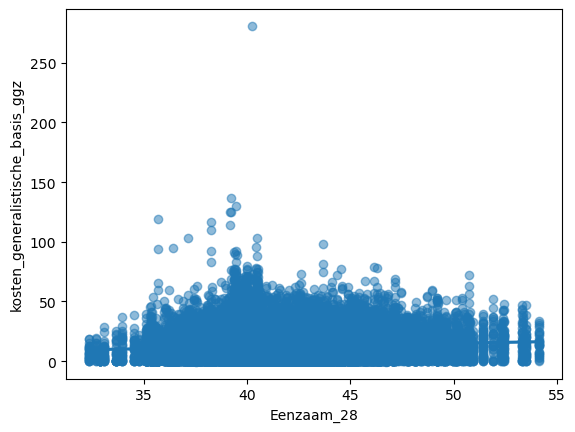

In [49]:
sns.regplot(y='kosten_generalistische_basis_ggz', x='Eenzaam_28', data=div, fit_reg=True, scatter_kws={'alpha':0.5})

<AxesSubplot:xlabel='Eenzaam_28', ylabel='kosten_generalistische_basis_ggz'>

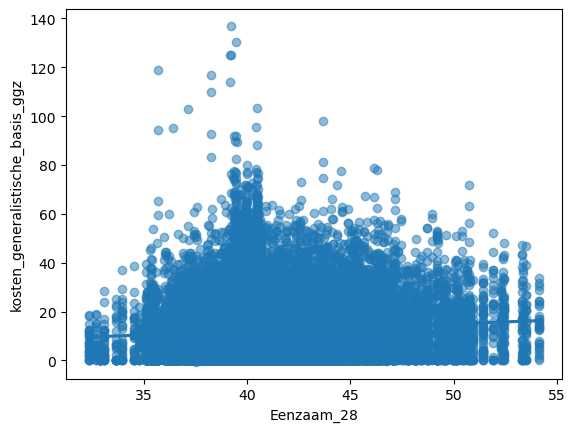

In [50]:
# remove the outliers from columns kosten_generalistische_basis_ggz and Eenzaam_28
do = div[div['kosten_generalistische_basis_ggz'] < 150]


sns.regplot(y='kosten_generalistische_basis_ggz', x='Eenzaam_28', data=do, fit_reg=True, scatter_kws={'alpha':0.5})

In [51]:
import statsmodels.formula.api as smf

modWt = smf.ols(formula='kosten_generalistische_basis_ggz ~ Eenzaam_28', data=do).fit()
print(modWt.summary())

                                   OLS Regression Results                                   
Dep. Variable:     kosten_generalistische_basis_ggz   R-squared:                       0.004
Model:                                          OLS   Adj. R-squared:                  0.004
Method:                               Least Squares   F-statistic:                     230.7
Date:                              Wed, 24 May 2023   Prob (F-statistic):           5.23e-52
Time:                                      22:47:29   Log-Likelihood:            -2.2031e+05
No. Observations:                             56794   AIC:                         4.406e+05
Df Residuals:                                 56792   BIC:                         4.406e+05
Df Model:                                         1                                         
Covariance Type:                          nonrobust                                         
                 coef    std err          t      P>|t|      [0.025    